# Function Definitions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu
import anndata
import seaborn as sns
import scanpy as sc 
# from itertools import combinations

In [3]:
def sample_cells_with_replacement(gene_cell_df, cell_name, sample_size=1000):
    current_cell_type_df = gene_cell_df[cell_name]
    num_columns = current_cell_type_df.shape[1]
    if num_columns < sample_size:
        print(f"{cell_name} has fewer than {sample_size} cells.")
        return current_cell_type_df
    sampled_indices = np.random.choice(range(num_columns), size=sample_size, replace=True)
    sampled_columns_df = current_cell_type_df.iloc[:, sampled_indices]
    return sampled_columns_df

In [4]:
def compute_empirical_covariance(imputed_expression):
    covariance_matrix = np.cov(imputed_expression, rowvar=False)
    gene_names = imputed_expression.columns
    covariance_matrix = pd.DataFrame(covariance_matrix, index=gene_names, columns=gene_names)
    return covariance_matrix

In [5]:
def log_volume_of_nonzero_singular_values(covariance_matrix):
    U, singular_values, V = np.linalg.svd(covariance_matrix, full_matrices=False)
    nonzero_singular_values = singular_values[singular_values > 10**(-30)] #1e-6 #1e-30 #plot range of eigenvalues
    log_volume = np.sum(np.log(nonzero_singular_values))
    total_genes = covariance_matrix.shape[0]
    normalized_log_volume = log_volume / total_genes
    return normalized_log_volume

In [6]:
def phenotypic_volume(adata, layer = None, subset = [], num_iterations = 20):
    if not layer:
        adata.layers["counts"] = adata.X.copy()
        #adata.obs['original_total_counts'] = adata.obs['total_counts']
        adata.obs['original_total_counts'] = adata.obs['nCount_RNA']
        sc.pp.normalize_total(adata, exclude_highly_expressed=True)
        sc.pp.log1p(adata)
        adata.layers["log_counts"] = adata.X.copy()
        df = adata.to_df(layer='log_counts').transpose()
    else:
        df = adata.to_df(layer = 'log_counts').transpose()
    
    if not subset:
        subset = list(pd.unique(df.columns))
    # print(subset)
    volumes = {}
    sample_size = 1000
    largest_cluster = float("-inf")
    for cell in subset:
        # print(df[cell])
        largest_cluster = max(df[cell].shape[1], largest_cluster)
    for cell in subset:
        current_cell_type_df = df[cell]
        num_columns = current_cell_type_df.shape[1]
        sample_size = min(sample_size, num_columns)
    num_iterations = 10*largest_cluster//sample_size
    for cell in subset:
        current_cell_type_df = df[cell]
        num_columns = current_cell_type_df.shape[1]
        sample_size = min(sample_size, num_columns)
    print(num_iterations)
    for cell in subset:
        cell_type_volumes = []
        for _ in range(num_iterations): #largest cluster/group of cells (n), every cell should have good probability 20*1000/n should be about 5-10ish
            X = sample_cells_with_replacement(df, cell, sample_size)
            Y = compute_empirical_covariance(X)
            Z = log_volume_of_nonzero_singular_values(Y)
            cell_type_volumes.append(Z)
        volumes[cell] = cell_type_volumes

    return pd.DataFrame(volumes)   

In [7]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Running PV on Data - T Cells

In [8]:
adata = sc.read('data/rm_tuft_neuroendocrine_acinar_tf_cd_8k.h5ad')

In [9]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb',
       'experiment', 'genotype', 'timepoint', 'mouse_id', 'replicate',
       'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.0.1',
       'pANN_0.25_0.02_26', 'doublet_finder', 'pANN_0.25_0.25_284',
       'pANN_0.25_0.02_6', 'pANN_0.25_0.02_15', 'pANN_0.25_0.07_53',
       'pANN_0.25_0.13_217', 'pANN_0.25_0.09_465', 'pANN_0.25_0.005_37',
       'pANN_0.25_0.06_64', 'compartment', 'RNA_snn_res.2', 'cluster1_1',
       'cluster2_1', 'cluster3_1', 'cluster4_1', 'cluster5_1', 'cluster6_1',
       'cell_type', 'decipher_split', 'decipher_z_clusters',
       'decipher_clusters', 'decipher_time'],
      dtype='object')

In [10]:
for subset in ["cell_type"]:
    adata = sc.read('data/rm_tuft_neuroendocrine_acinar_tf_cd_8k.h5ad')
    adata.obs_names = adata.obs[subset]
    PV = phenotypic_volume(adata)
    PV.to_csv(f'data/pdac-{subset}.csv')

cell_type   acinar 2  acinar 2  acinar 2  acinar 2  acinar 2  acinar 2  \
gene                                                                     
Rp1              0.0       0.0       0.0       0.0       0.0       0.0   
Sox17            0.0       0.0       0.0       0.0       0.0       0.0   
Gm37323          0.0       0.0       0.0       0.0       0.0       0.0   
Rgs20            0.0       0.0       0.0       0.0       0.0       0.0   
Oprk1            0.0       0.0       0.0       0.0       0.0       0.0   
...              ...       ...       ...       ...       ...       ...   
mt-Nd6           0.0       0.0       0.0       0.0       0.0       0.0   
Spry3            0.0       0.0       0.0       0.0       0.0       0.0   
AC133103.1       0.0       0.0       0.0       0.0       0.0       0.0   
AC132444.6       0.0       0.0       0.0       0.0       0.0       0.0   
AC125149.3       0.0       0.0       0.0       0.0       0.0       0.0   

cell_type   acinar 2  acinar 2  acina

In [5]:
df = pd.read_csv('data/pdac-cell_type.csv', index_col=0)
df.head()

,acinar 2,adm,panin 1,acinar 1,early pdac,panin 2,pdac 2,pdac 1,gastric,emt
0,-5.535745,-4.774834,-6.689272,-5.036867,-3.689515,-3.674563,-4.313613,-3.169641,-14.456801,-14.156231
1,-4.251985,-4.376612,-7.735093,-5.408109,-3.662457,-4.101277,-4.265477,-3.464284,-12.337306,-15.522606
2,-6.467880,-4.423056,-6.653474,-6.707782,-4.400009,-4.414708,-3.929639,-4.834567,-11.974713,-14.544682
3,-3.294678,-4.386883,-7.336877,-4.657140,-3.668648,-3.402886,-2.927240,-3.776553,-12.699768,-13.854453
4,-3.942421,-4.018772,-8.015086,-5.364802,-4.350737,-4.044064,-4.619483,-4.154743,-12.389756,-15.558748


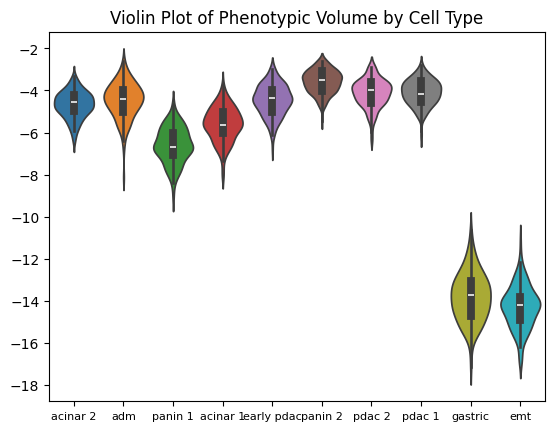

In [9]:
# Create the violin plot
sns.violinplot(data=df)

# Add a title
plt.title('Violin Plot of Phenotypic Volume by Cell Type')
plt.xticks(fontsize=7)

# Show the plot
plt.savefig('figures/pdac_PV_violin.png')
plt.show()

# Running PV on Data - Tumor

In [8]:
adata_origin = sc.read('data_tum_merged_v5.h5ad')

In [9]:
adata = adata_origin.copy()

In [10]:
adata = sc.pp.subsample(adata, fraction=0.1, copy=True)

In [11]:
response_map = {'CR': 'R', 'PR': 'R', 'SD':'NR', 'PD':'NR'}
for response in response_map:
    adata.obs['best_response'] = adata.obs['best_response'].replace(response, response_map[response])
adata.obs_names = adata.obs['best_response']
PV = phenotypic_volume(adata)
PV.to_csv(f'tumor-response-10percent.csv')

178


In [12]:
adata_origin = sc.read('data_tum_merged_v5.h5ad')

In [13]:
adata = adata_origin.copy()
adata = sc.pp.subsample(adata, fraction=0.1, copy=True)

In [14]:
adata.obs_names = adata.obs['time']

In [15]:
PV = phenotypic_volume(adata)
PV.to_csv(f'tumor-time-10percent.csv')

106


In [18]:
adata_origin = sc.read('data_tum_merged_v5.h5ad')
adata = adata_origin.copy()
adata = sc.pp.subsample(adata, fraction=0.1, copy=True)
response_map = {'CR': 'R', 'PR': 'R', 'SD':'NR', 'PD':'NR'}
for response in response_map:
    adata.obs['best_response'] = adata.obs['best_response'].replace(response, response_map[response])
concatenated_values = adata.obs["best_response"].astype(str) + '_' + adata.obs["time"].astype(str)
adata.obs_names = concatenated_values
PV = phenotypic_volume(adata)
PV.to_csv(f'tumor-response-plus-time-10percent.csv')

73
